In [ ]:
## Chapter 4: Under the Hood: Training a Digital Classifier

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner
from fastai.text.all import *
from fastai.tabular.all import *
from fastai.collab import *
from fastai.basics import *
from torchvision.models import resnet34
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import Dropdown, VBox, Button, Layout, Label, interact
import os
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import shutil
import torch

In [2]:
## use doc() to answer questions about a fastai method

# What is untar_data
doc(untar_data)

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
Download `url` using `FastDownload.get`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [3]:
# use untar_data to extract urls and return the paths 
# this creates the following path: '/root/.fastai/data/mnist_sample'
# download samples of the NIST images of 3 or 7
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
# Set the base path
Path.BASE_PATH = 'train'

# Define the paths
train_path = path/'train'
valid_path = path/'valid'
csv_path = path/'labels.csv'

# Create directories if they don't exist
train_path.mkdir(parents=True, exist_ok=True)
valid_path.mkdir(parents=True, exist_ok=True)

# Create the labels.csv file (you can replace '...' with actual label data)
labels_data = pd.DataFrame({'file': [], 'label': []})
labels_data.to_csv(csv_path, index=False)

# Check the updated directory structure
## list folders for training, validation, and test data
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

In [5]:
# list the training data folders
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [6]:
sevens = (path/'train'/'7').ls().sorted()
threes = (path/'train'/'3').ls().sorted()

In [7]:
# list the threes (image files)
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [8]:
## Goal: demonstrate what an image looks like to a computer ##
# view an image of a three
# the Image class comes from the Python Imaging Library (PIL)
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
## Goal: demonstrate what an image looks like to a computer ##
# convert the image of the 3 to a NumPy array 
# ensure numpy is imported as np
# [rows, columns]
# index rows / columns 4 up to 10 (not included)
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
## Goal: demonstrate what an image looks like to a computer ##
# convert the image of the 3 to a PyTorch tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
## Goal Complete: This is what an image looks like to a computer ##
# slice the array to pick just the part with the top digit in it
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [12]:
## Goal Complete: This is what an image looks like to a computer ##
# use a Pandas DataFrame to color-code the values with a gradient
# 0's are white; 255's are black; shades of grey are between 0 and 255
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [13]:
## Goal: create a very simple baseline model using averages
# creat a tensor for all images of 3 and 7 in a directory
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

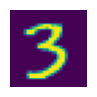

In [14]:
## Goal: create a very simple baseline model using averages
# check one of the images using the fastai show_image() method
show_image(three_tensors[1])

In [15]:
## Goal: create a very simple baseline model using averages
# combine all of the images in the 3s and 7s lists into a single three-dimensional tensor
# use the PyTorch stack() method to stack up individual tensors into a single tensor
# cast the stacked tensor into a float and divide by 255 to get a number from 0 to 1
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

In [16]:
## Goal: create a very simple baseline model using averages
# an important attribute of a tensor is its shape which tells you the length of each axis
# we have 6,131 images, each of size 28×28 pixels.
stacked_threes.shape

torch.Size([6131, 28, 28])

In [17]:
## Goal: create a very simple baseline model using averages
# the length of a tensor's shape is  its rank
# this is a rank-3 tensor
len(stacked_threes.shape)

3

In [18]:
## Goal: create a very simple baseline model using averages
# get a tensor's rank directly with ndim
stacked_threes.ndim

3

<Axes: >

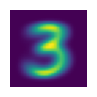

In [19]:
## Goal: create a very simple baseline model using average
# determine the ideal 3 in our rank-3 tensor
# calculate the mean of all the image tensors 
# for every pixel position, compute the average of that pixel over all images
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

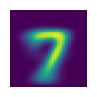

In [20]:
## Goal: create a very simple baseline model using average
# determine the ideal 7 in our rank-3 tensor
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<Axes: >

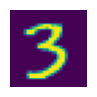

In [21]:
## Goal: create a very simple baseline model using average
# we will measure the distance from this aribrary '3' to our "ideal 3"

# pick an arbitrary 3 
a_3 = stacked_threes[1]
show_image(a_3)

In [22]:
## Goal: create a very simple baseline model using average
# measuring distance
# method 1: Mean Absolute Difference (a.k.k L1 norm) 
dist_3_abs = (a_3 - mean3).abs().mean()

# method 2: Root Mean Squared Error (RRMSE)(a.k.a L2 norm)
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

# display the distances
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

<Axes: >

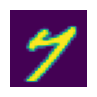

In [23]:
## Goal: create a very simple baseline model using average
# we will measure the distance from this aribrary '7' to our "ideal 7"

# pick an arbitrary 7
a_7 = stacked_sevens[1]
show_image(a_7)

In [24]:
## Goal: create a very simple baseline model using average
# measuring distance

# method 1: Mean Absolute Difference (a.k.k L1 norm) 
# dist_7_abs = (a_7 - mean7).abs().mean() 
dist_7_abs = (a_3 - mean7).abs().mean() # Note: why use a_3 - mean7 ??

# method 2: Root Mean Squared Error (RRMSE)(a.k.a L2 norm)
# dist_7_sqr = ((a_7 - mean7)**2).mean().sqrt()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt() # Note: why use a_3 - mean7 ??

# display the distance
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [25]:
## Goal: create a very simple baseline model using average
# measuring distance using the PyTorch loss function
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [26]:
## Goal complete: create a very simple baseline model using average
# measuring distance

# The distance between our 3 and the "ideal" 3 < the distance to the ideal 7. 
# So our simple model will give the right prediction in this case.

# now let's compare the results
print(f'3s: {dist_3_abs, dist_3_sqr}\n')
print(f'7s {dist_7_abs, dist_7_sqr}\n')
print(f'loss function: {F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3,mean7).sqrt()}')

3s: (tensor(0.1114), tensor(0.2021))

7s (tensor(0.1586), tensor(0.3021))

loss function: (tensor(0.1586), tensor(0.3021))


In [27]:
# my notes 
# Smaller values indicate closer similarity. 
# The RMSE is higher than the MAE  
# There are possibly some pixels with relatively larger errors,...
# pulling the RMSE up more than the MAE.

### Now, is our baseline model any good? ### 

In [28]:
# Quick lesson on numpy arrays and PyTorch tensors

data = [[1,2,3],[4,5,6]]

# create a numpy array
arr = array(data)

# create a PyTorch tensor
tns = tensor(data)


In [29]:
# Quick lesson on numpy arrays and PyTorch tensors

# display the numpy array
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [30]:
# Quick lesson on numpy arrays and PyTorch tensors

# display the PyTorch tensor
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [31]:
# Quick lesson on numpy arrays and PyTorch tensors
# basic operations on tensors (most are similar to numpy)

# display a row
# display index 1 (element 2) of the tensor
tns[1]

tensor([4, 5, 6])

In [32]:
# Quick lesson on numpy arrays and PyTorch tensors
# basic operations on tensors (most are similar to numpy)

# display a column
# show all of the first axis (index column 1)
tns[:,1]

tensor([2, 5])

In [33]:
# Quick lesson on numpy arrays and PyTorch tensors
# basic operations on tensors (most are similar to numpy)

# select part of a row or column
# second list element [4,5,6] indexes 1 through 3 (excluding 3) so index 1 and 2
tns[1,1:3]

tensor([5, 6])

In [34]:
# Quick lesson on numpy arrays and PyTorch tensors
# basic operations on tensors (most are similar to numpy)

# perform operations on tensors
# add one to each element of the tensor
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [35]:
# Quick lesson on numpy arrays and PyTorch tensors
# basic operations on tensors (most are similar to numpy)
# check the tensor type
tns.type()

'torch.LongTensor'

In [36]:
# Quick lesson on numpy arrays and PyTorch tensors
# basic operations on tensors (most are similar to numpy)
# automatically changes from int to float
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

In [37]:
### Now, is our baseline model any good? ### 
# Goal: build a metric
# next step: check the shape of the images 
# create tensors for the 3s and 7s from the 'valid' directory
# these tensors are used to calculate a metric measuring the quality of the model
# the metric measures distance from an ideal image

valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

# display the number of images and the shape (remember definition of shape)
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [38]:
### Now, is our baseline model any good? ### 
# Goal: build a metric
# next step: write a function to decide if an aribrary number is a 3 or 7

# define a function that calculates the distance between two images
# applies the method "elementwise"
# returns 1010 matrices of absolute values
# (-1, -2) are the last two axes (horizontal and vertical dimensions) in an image
# .mean(-1,-2) takes the mean of the last two axes  in the image
# after taking the mean of (-1, -2) we are left with the first tensor axis
# the first tensor axis index over all of the images
# so we get the average intensity of all the pixels in that image
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))

# call the distance calculator function
# result is the same value we previously calculated for the distance
mnist_distance(a_3, mean3)

tensor(0.1114)

In [39]:
### Now, is our baseline model any good? ### 
# Goal: build a metric
# next step: **Apply broadcasting technque**

# option 1: loop over 'valid_3_tens',the stacked ismage tensors in the validation set
# option 2 (better): pass 'valid_3_tens' as an argument into mnist_distance function

# pass the tensor for the 3s and the mean as arguments into the distance func
# PyTorch will automatically apply the broadcasting technique
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1270, 0.1632, 0.1676,  ..., 0.1228, 0.1210, 0.1287]),
 torch.Size([1010]))

In [40]:
## My Notes on Broadcasting ##
# Shape Transformation 
# Tensor A (3x4 matrix)
A = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
]

# Tensor B (1D vector)
B = [1, 2, 3, 4]

# Convert B to a 2D tensor with shape (1, 4)
B_padded = [B]  # This is now [[1, 2, 3, 4]], which is shape (1, 4)

# Broadcast B to match the shape of A (3, 4)
B_broadcast = [
    [1, 2, 3, 4],
    [1, 2, 3, 4],
    [1, 2, 3, 4]
]


In [41]:
### Now, is our baseline model any good? ### 
# Goal: build a metric
# next step: use mnist_distance to test an arbitrary 3
# logic: 
# if (distance between 'ideal 3' and image) < (distance to 'ideal 7') then image = 3

def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x, mean7)

# test an image
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [42]:
### Now, is our baseline model any good? ### 
# Goal: build a metric
# next step: use mnist_distance to test the validation set of 3s
is_3(valid_3_tens)

tensor([ True, False, False,  ...,  True,  True, False])

In [43]:
### Our baseline model is pretty good ### 
# Goal Complete: buitl a metric
# final step: calculate the accuracy for each of the 3s and 7s
# take the average of the function for all 3s and its inverse for all 7s
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1- is_3(valid_7_tens).float()).mean()

# display the accuracy of the 3s and 7s
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

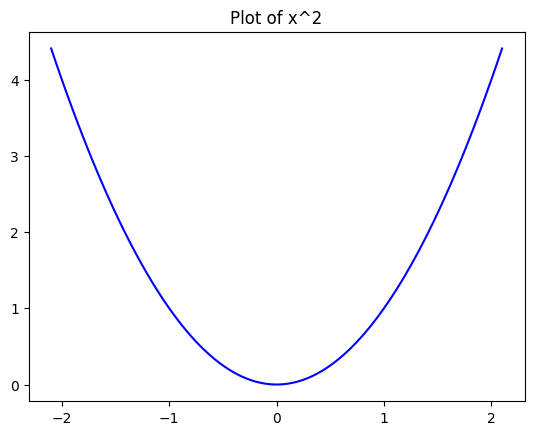

In [44]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 

# build the plot_function
def plot_function(f, title=None, min=-2.1, max=2.1, color='b', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

# a quadratic loss function where x is a weight parameter
def f(x): return x**2

# pass the f function as an argument into the plot_function method
# display the loss function
plot_function(f, title='Plot of x^2')

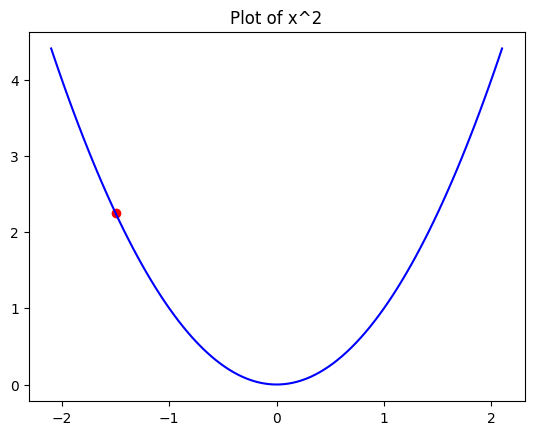

In [45]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 

# next step: pick some random value for a parameter 
# f(-1.5) = 2.25 (x,y) = (-1.5, 2.25)
# calculate the loss
plot_function(f, title='Plot of x^2')
plt.scatter(-1.5, f(-1.5), color='red')

In [46]:
## here is how to calculate a gradient ##

# define the function
def f(x): return x**2

# create a tensor with requires_grad=True
x = torch.tensor(3.0, requires_grad=True)

# compute the function value
y = f(x)

# compute the gradient
y.backward()

# access the gradient
gradient = x.grad

print(f"Gradient of f(x) = x^2 at x = {x.item()} is {gradient.item()}")

Gradient of f(x) = x^2 at x = 3.0 is 6.0


In [47]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 

# next step: calculate a gradient
# pick a tensor value which we want gradients at
xt = tensor(3.).requires_grad_()

In [48]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 
# next step: calculate a gradient

# calculate our function with the value
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [49]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 
# next step: calculate a gradient

# backpropagation is the proces of calculating the derivative of each layer
yt.backward()

In [50]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 

# view the gradients
# check the grad attribute of our tensor
xt.grad

tensor(6.)

In [51]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 

# calculate a gradient with a vector argument
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [52]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 

# add sum to the function so it can take a vector
def f(x): return (x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [53]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 

yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

In [54]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 

## gradients only tell us the slope of our function ##
## gradients do not tell us exactly how far to adjust the parameters ##
# a very large slope suggests we need more adjustments
# a very small slope may suggest that we are close to the optimal value

In [55]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: build a simple loss function 
# next step: stepping with a learning rate (LR)

# define a function
def h(x): return x**2

# create a tensor with requires_grad=True
# use an initial value of 3.0
x = torch.tensor(3.0, requires_grad=True)

# define the learning rate
learning_rate = 0.1

# perform a single gradient descent step
# do 10 iterations 
for i in range (10):
    y = h(x)
    y.backward() # compute the gradient using backpropagation
    
    # update x using the gradient and learning rate
    with torch.no_grad(): # temporarily set requires_grad to False
        x -= learning_rate * x.grad
    
    # zero the gradients after updating
    x.grad.zero_()
    
    print(f"Iteration {i+1}: x = {x.item()}")

# final value of x
print(f"Final value x: {x.item()}")

Iteration 1: x = 2.4000000953674316
Iteration 2: x = 1.9200000762939453
Iteration 3: x = 1.5360000133514404
Iteration 4: x = 1.2288000583648682
Iteration 5: x = 0.9830400347709656
Iteration 6: x = 0.7864320278167725
Iteration 7: x = 0.629145622253418
Iteration 8: x = 0.5033165216445923
Iteration 9: x = 0.40265321731567383
Iteration 10: x = 0.32212257385253906
Final value x: 0.32212257385253906


In [56]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# next step: create the time tensor with values from 0 to 19 (inclusive)
# manually measure the speed every 20 seconds
# This tensor represents the time points at which we measure the speed of the roller coaster
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [57]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# next step: generate the speed tensor
# represents the speed of the roller coaster at each time point.
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 +1
speed

#### explanation ###
# torch.randn(20) * 3: 
# creates a tensor of 20 random values sampled from a standard normal distribution 
# multiplies each value by 3
# adds a stochastic (random) component to the speed to simulate noise

# 0.75 * (time - 9.5) ** 2: 
# models a quadratic function centered around time = 9.5. The ** 2 operation squares the difference between each time value and 9.5, and the 0.75 coefficient controls the curvature of the quadratic function. This simulates the expected change in speed as the roller coaster approaches the top of the hump (slowing down as it climbs and then speeding up as it descends).

# + 1: 
# adds a baseline speed of 1 to all values
# ensures that the speed remains positive and does not drop too low

tensor([63.5522, 56.3624, 43.7545, 31.7773, 29.6053, 16.3925,  9.5689,  7.1545,
         8.0498,  0.2769,  3.7202,  5.9367,  7.1613, 12.6352, 14.6152, 25.4638,
        31.3014, 45.3566, 55.4162, 64.7234])

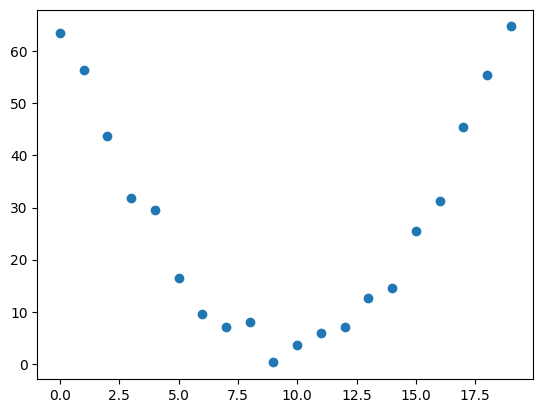

In [58]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# next step: make a scatter plot of the roller coaster speed
plt.scatter(time,speed)

In [59]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# let's guess and start with a quadratic of the form a*(time**2) + (b*time) + c

# next step: collect the parameters into one argument
# find the best quadratic
def f(t, params):
    a, b, c = params 
    return a*(t**2) + (b*t) + c

In [60]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model

# next step: apply SGD to minimize loss
# for continuous data use the mean squared error 
def mse(pred, targets): return ((preds - targets)**2).mean()

In [61]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# apply the 7-step process

# step 1: initialize the parameters
# initialize the parameters to random values and track their gradients
# create a 1-dimensional tensor of size 3 filled with random values
# random values are sampled from a standard normal distribution
params = torch.randn(3).requires_grad_()
params

## notes: params represent the parameters (weights) of the model that you want to optimize
## Setting requires_grad=True computes gradients during the training process. 

tensor([ 1.5212, -1.1831,  0.4164], requires_grad=True)

In [62]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# step 2: calculate the predictions
preds = f(time,params)
preds

tensor([4.1642e-01, 7.5446e-01, 4.1348e+00, 1.0558e+01, 2.0023e+01, 3.2530e+01,
        4.8080e+01, 6.6672e+01, 8.8306e+01, 1.1298e+02, 1.4070e+02, 1.7146e+02,
        2.0527e+02, 2.4211e+02, 2.8200e+02, 3.2493e+02, 3.7091e+02, 4.1992e+02,
        4.7198e+02, 5.2708e+02], grad_fn=<AddBackward0>)

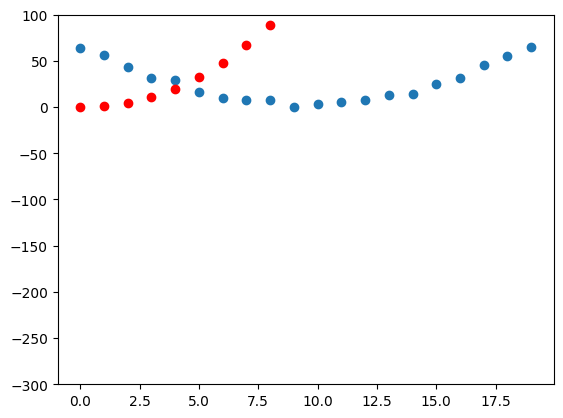

In [63]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# step 2 (continued): create a function to see how close our predictions are to our targets
def show_preds(preds, ax=None):
    if ax is None: 
        ax=plt.subplots()[1]
    ax.scatter(time,speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
show_preds(preds)

## graphic displays negative speeds!!! So, we need to fix this

In [64]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# step 3: calculate the loss
loss = mse(preds, speed)
loss

# next we need to improve the loss but first we need to know the gradients

tensor(48789.8125, grad_fn=<MeanBackward0>)

In [65]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# step 4: calculate the gradients
# calculate an approximation of how the parameters need to change
loss.backward()
params.grad

tensor([73630.3281,  4701.8716,   300.8002])

In [66]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# step 4 (continued): choose a learning rate of 1e-5
params.grad * 1e-5
params

tensor([ 1.5212, -1.1831,  0.4164], requires_grad=True)

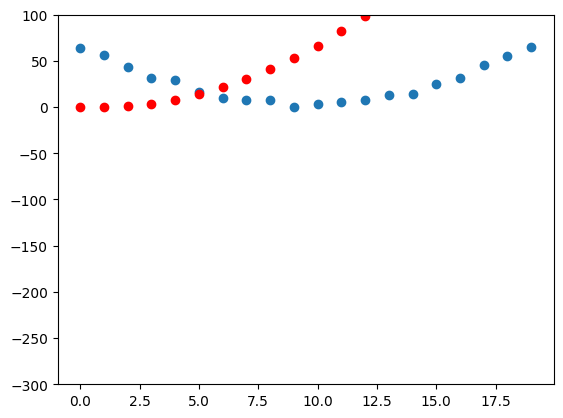

In [67]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# step 5: step the weights
# update the parameters based on the gradients we just calculated
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

# now see if the loos has improved
preds = f(time, params)
mse(preds, speed)

show_preds(preds)

In [68]:
# Note to self: if you get the RuntimeError: 
# "Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed)."
# go back to the top and rerun all the cells

## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# step 6: repeat the process
# We need to repeat this a few times, so we'll create a function to apply one step
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward(retain_graph=True)
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

for i in range(10): apply_step(params)

# def apply_step(params, prn=True):
#     preds = f(time, params)
#     loss = mse(preds, speed)
#     loss.backward(retain_graph=True)  # Retain the computation graph
#     with torch.no_grad():
#         params.data -= lr * params.grad
#     params.grad.zero_()
#     if prn: print(loss.item())
#     return preds

# for i in range(10): apply_step(params)


9731.630859375
9731.630859375
9731.630859375
9731.630859375
9731.630859375
9731.630859375
9731.630859375
9731.630859375
9731.630859375
9731.630859375


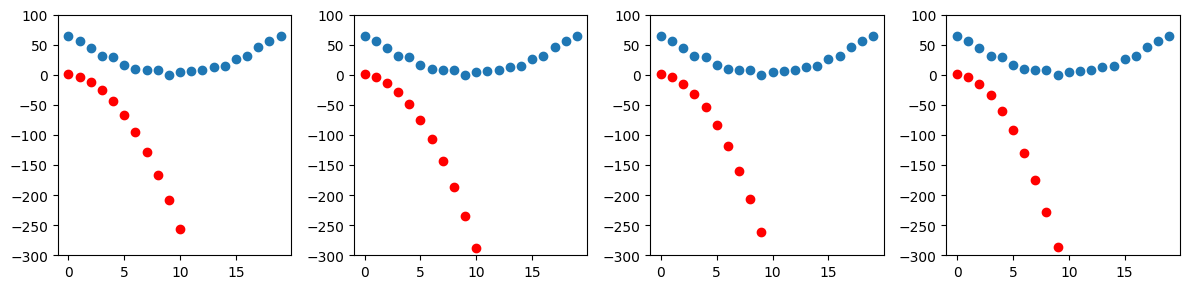

In [69]:

# Note to self: if you get the RuntimeError: 
# "Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed)."
# go back to the top and rerun all the cells

## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal complete: Build an End-to-End SGD Example 
# model the speed of a roller coaster as it went over the top of a hump

# intermediate goal: find a function to fit the model
# step 6 (continued): display the interations
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [70]:
## Training Process and Stochastic Gradient Descent (SGD) ##
# Goal complete: Build an End-to-End SGD Example 
# Step 7: stop
# We just decided to stop after 10 epochs arbitrarily. 
# In practice, the training and validation losses and metrics decide when to stop


In [71]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights + bias) using gradients to predict a 3

# concatenate the images (x-variables) into a single tensor
# change the shape of the tensor without chaning its content
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [72]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights + bias) using gradients to predict a 3
# a dataset in PyTorch is required to return a tuple of (x,y) when indexed. 
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [73]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights + bias) using gradients to predict a 3

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [74]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# y=w*x+b 
# The w in the equation is called the weights and the b is called the bias. 
# Together, the weights and bias make up the parameters.

# create an (initially random) weight for every pixel
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))

# The function weights*pixels is always equal to 0 when the pixels are equal to 0
# So, initialize it with a randome number for more flexibility
bias = init_params(1)

# calculate a prediction for one image using y = wx + b
(train_x[0]*weights.T).sum() + bias

tensor([-2.6162], grad_fn=<AddBackward0>)

In [75]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# matrix multiplication
# The equation, batch@weights + bias, is one of the two fundamental equations of any neural network
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -2.6162],
        [-19.2876],
        [ -5.5027],
        ...,
        [  6.9382],
        [  9.1032],
        [  5.7424]], grad_fn=<AddBackward0>)

In [76]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# use broadcasting to check our accuracy (decide if an output represents a 3 or a 7)
# check whether the output is greater than 0.0 to 
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [77]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

corrects.float().mean().item()

0.2575830817222595

In [78]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# make a small adjustment to the weight and observe the accuracy
# note we have to ask PyTorch not to calculate gradients as we do this
with torch.no_grad(): weights[0] *=1.0001
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

## output 
#  small changes in the value of a weight will often not change the accuracy at all
# ** It is not useful to use accuracy as a loss function ** #

0.2575830817222595

In [79]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# develop a loss function 
# loss func gives us a slightly better loss when adjusting our weights result in slightly better predictions

## lesson on loss ##
# loss measures the distance between the predictions and targets
# suppose we had three images which are 3, 7, 3 (the targets)
# suppose the model predicts 0.9, 0.4,and 0.2 
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

# measure how distant each prediction is from 1 if it should be 1
# measure how distant each prediction is from 0 if it should be 0
# take the mean of all those distances
# note this uses the PyTorch function where()  
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

# now run the loss function on the test data 3, 7, 3
# In PyTorch, we always assume a lower value of a loss function is better. 
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [80]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

## lesson on loss ##
# compute the final loss
# we need a scalar for the final loss
# mnist_loss takes the mean of the previous tensor
mnist_loss(prds,trgts)

tensor(0.4333)

In [81]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

## lesson on loss ##
# change our prediction for the "false" target from 0.2 to 0.8
# the loss will go down
mnist_loss(tensor([0.9,0.4,0.8]),trgts)

tensor(0.2333)

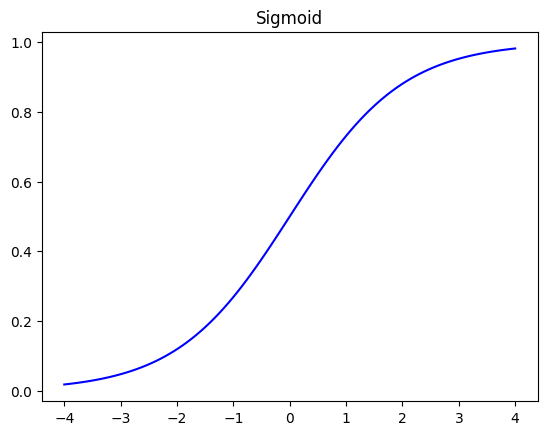

In [82]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# The Sigmoid Function ensures the output is always a number between 0 and 1.

# create your own sigmoid function  
def sigmoid(x): return 1 /(1+toch.exp(-x))

# PyTorch Sigmoid Function
plot_function(torch.sigmoid, title="Sigmoid", min=-4, max=4)

In [83]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# The Sigmoid Function ensures the output is always a number between 0 and 1.
# update mnist_loss to first apply sigmoid to the inputs
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [84]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# Optimization Step and Mini-Batches
# take a random selection of data (mini-batch) and iterate the loss function

# mini-batch example
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([3, 7, 4, 2, 6]),
 tensor([ 8, 14,  5,  1, 11]),
 tensor([13, 10,  9, 12,  0])]

In [85]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3

# mini-batch example with x and y variables
ds = L(enumerate(string.ascii_lowercase))
print(ds)
print()

dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e'), (5, 'f'), (6, 'g'), (7, 'h'), (8, 'i'), (9, 'j'), (10, 'k'), (11, 'l'), (12, 'm'), (13, 'n'), (14, 'o'), (15, 'p'), (16, 'q'), (17, 'r'), (18, 's'), (19, 't'), (20, 'u'), (21, 'v'), (22, 'w'), (23, 'x'), (24, 'y'), (25, 'z')]



[(tensor([ 6,  8, 18, 19, 14,  1]), ('g', 'i', 's', 't', 'o', 'b')),
 (tensor([17,  2,  0, 15, 12, 11]), ('r', 'c', 'a', 'p', 'm', 'l')),
 (tensor([ 9,  7, 21,  4, 23, 16]), ('j', 'h', 'v', 'e', 'x', 'q')),
 (tensor([25,  3, 22, 10,  5, 20]), ('z', 'd', 'w', 'k', 'f', 'u')),
 (tensor([24, 13]), ('y', 'n'))]

In [86]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD (optimization step)

# Our process will be implemented something like this for each epoch:
# for x,y in dl:
#     pred = model(x)
#     loss = loss_func(pred,y)
#     loss.backward()
#     parameters -= parameters.grad*lr

# re-initialize our parameters:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()
weights = init_params((28 * 28, 1))
bias = init_params(1)

# create the DataLoader from a dataset
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [87]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# create the DataLoader for the validation set
valid_dl = DataLoader(valid_dset, batch_size=256)

In [88]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# create a mini-batch of size 4 for testing
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [89]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# mini-batch of predictions
preds = linear1(batch)
preds

tensor([[ 1.1931],
        [ 5.4445],
        [ 3.4859],
        [-2.6709]], grad_fn=<AddBackward0>)

In [90]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# apply the loss function
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.3005, grad_fn=<MeanBackward0>)

In [91]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# calculate the gradients
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0102), tensor([-0.0681]))

In [92]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# place this all into a function
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds,yb)
    loss.backward()

# call the calc_grad function
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0204), tensor([-0.1361]))

In [93]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# The gradients will change if we call the calc_grad func twice
# call the calc_grad function
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

# loss.backward adds the gradients of loss to any gradients that are currently stored 


(tensor(-0.0307), tensor([-0.2042]))

In [94]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# Set the current gradients to 0 first
weights.grad.zero_()
bias.grad.zero_();

In [95]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# update the weights and biases based on the gradient and learning rate
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [96]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# check how we're doing by looking at the accuracy of the validation set
# decide if an output represents a 3 or a 7 (check whether it's greater than 0)
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [ True],
        [False]])

In [97]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# calculate our validation accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

# verify that our function works
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

In [98]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# put the batches together
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.5272

In [99]:
## Lesson: Improving the MNIST Loss Function ##
# Goal: update the parameters (weights) using gradients to predict a 3
# Goal: Write our first training loop for a model using SGD

# train for one epoch to see if the accuracy improves
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6532

In [100]:
## Lesson: Improving the MNIST Loss Function ##
# Goal Complete: update the parameters (weights) using gradients to predict a 3
# Goal Complete: Write our first training loop for a model using SGD

# train for a few more epochs to see if the accuracy improve
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end='')

0.85530.92180.93840.94760.95640.96230.96470.96670.96820.96960.97160.97260.9740.97450.9740.9740.9740.97450.9750.975

In [101]:
## Lesson: Improving the MNIST Loss Function ##
# Create an Optimizer using PyTorch's nn.Linear module. 

# nn.Linear does the same thing as our init_params and linear together
# nn.Linear  contains both the weights and biases in a single class
linear_model = nn.Linear(28*28,1)

# define the parameters
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [102]:
## Lesson: Improving the MNIST Loss Function ##
# Create an Optimizer using PyTorch's nn.Linear module. 

# create the optimizer
class BasicOptim:
    def __init__(self,params,lr): 
        self.params, self.lr = list(params),lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
# pass in the model's parameters
opt = BasicOptim(linear_model.parameters(), lr)

# training loop
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

# keep the same validation function
validate_epoch(linear_model)

0.5768

In [103]:
## Lesson: Improving the MNIST Loss Function ##
# Create an Optimizer using PyTorch's nn.Linear module. 

# place the training loop in a function
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

# the results should be the same as the previous section
train_model(linear_model, 20)

0.4932 0.7885 0.8569 0.9174 0.937 0.9497 0.9575 0.9633 0.9667 0.9687 0.9706 0.9721 0.9736 0.975 0.976 0.977 0.9775 0.978 0.9785 0.9789 

In [104]:
## Lesson: Improving the MNIST Loss Function ##
# Create an Optimizer using PyTorch's nn.Linear module. 

# the fastai SGD class which, by default, does the same thing as our BasicOptim
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.9028 0.812 0.9072 0.9316 0.9462 0.9555 0.9623 0.9648 0.9682 0.9697 0.9721 0.9731 0.975 0.9755 0.9765 0.9775 0.978 0.9785 0.9785 

In [105]:
## Lesson: Improving the MNIST Loss Function ##
# Use fastai Learner.fit instead of train_model

# create a learner
dls = DataLoaders(dl, valid_dl)

# pass in all the elements that we've created 
# - DataLoaders
# - model, 
# - optimization function, 
# - loss function, 
# - any metrics to print (optional)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
# call fit()
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636904,0.503632,0.495584,00:00
1,0.588758,0.149205,0.887635,00:00
2,0.213535,0.198947,0.816487,00:00
3,0.091936,0.111744,0.909715,00:00
4,0.047280,0.080010,0.933268,00:00
5,0.029971,0.063472,0.945535,00:00
6,0.022932,0.053357,0.955348,00:00
7,0.019863,0.046708,0.962218,00:00
8,0.018350,0.042073,0.965162,00:00
9,0.017467,0.038676,0.966634,00:00


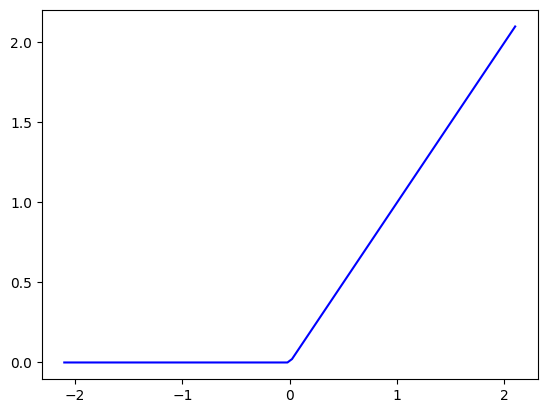

In [106]:
# Lesson: Define a simple feedforward neural network with one hidden layer
# Goal Complete: Use the PyTorch and fastai classes to develop a neural network

# update the linear function by adding nonlinearity to it
# Here is the entire definition of a basic neural network
# simple_net is two linear classifiers with a max function between them
# res.max(tensor(0.0)) is called a rectified linear unit, also known as ReLU
# ReLU replaces every negative number with a zero. 
def simple_net(xb):
    res = xb@w1 + b1  # first layer (hidden layer)
    res = res.max(tensor(0.0)) # ReLU is an activation function
    res = res@w2 + b2 # second layer
    return res

# create the parameters that are initially randomized
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

# ReLU function is also  in PyTorch as F.relu
plot_function(F.relu)

In [107]:
# Lesson: Define a simple feedforward neural network with one hidden layer
# Repeat the process using PyTorch

# create a one-layer neural network
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

# test the model
# use a lower learning rate and a few more epochs since this is a deeper model
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.341230,0.392119,0.518646,00:00
1,0.156128,0.234418,0.793425,00:00
2,0.085051,0.115446,0.916094,00:00
3,0.054850,0.077017,0.944553,00:00
4,0.040995,0.059911,0.958783,00:00
5,0.034029,0.050443,0.965162,00:00
6,0.030096,0.044512,0.966634,00:00
7,0.027577,0.040462,0.968597,00:00
8,0.025782,0.037512,0.969578,00:00
9,0.024398,0.035256,0.970069,00:00


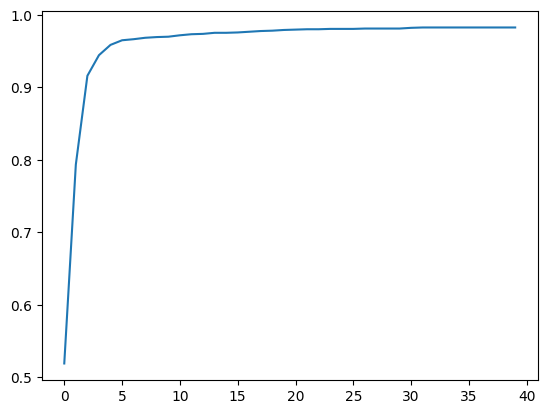

In [108]:
# Lesson: Define a simple neural network with one hidden layer

# plot the accuracy over training 
plt.plot(L(learn.recorder.values).itemgot(2))

In [109]:
# Lesson Complete: Define a simple neural network with one hidden layer

# view the final accuracy of the model
learn.recorder.values[-1][2]

0.982826292514801

In [110]:
### Ch. 4 Complete